In [2]:
import pandas as pd
import pandas
import numpy as np
import sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from flaml import AutoML

claims_data = pd.read_excel('claims_data.xlsx')

In [3]:
bins = [-1, 0, 50000]
labels = [0, 1]

# Categorize the 'loss' column
claims_data['Incurred_cat'] = pd.cut(claims_data['Incurred'], bins=bins, labels=labels)

In [4]:
claims_data = claims_data[~claims_data['Incurred_cat'].isna()]

In [5]:
claims_data.loc[claims_data["Notification_period"] < 0, "Notification_period"] = np.nan
claims_data.loc[claims_data["PH_considered_TP_at_fault"] == "#", "PH_considered_TP_at_fault"] = np.nan
claims_data.drop(columns=["Claim Number", "date_of_loss", "Loss_code", "Loss_description", "Capped Incurred"],
                 inplace=True)

claims_data = claims_data[~claims_data['Incurred_cat'].isna()] # removed instances where Incurred_cat is NaN because loss was negative. Likely a mistake in the data or sued for expenses. Not enough cases to validate keeping it in. 

for col in claims_data.select_dtypes(include=["object"]).columns:
    claims_data[col] = claims_data[col].astype("category")

def one_hot_encode_categorical_columns(df: pd.DataFrame) -> (pd.DataFrame, OneHotEncoder):
    """
    One-hot encodes all categorical columns in the DataFrame using OneHotEncoder.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing columns to be encoded.
    
    Returns:
    pd.DataFrame: The DataFrame with categorical columns one-hot encoded.
    """
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    ohe = OneHotEncoder(sparse_output=False, drop='first')
    encoded_df = pd.DataFrame(ohe.fit_transform(df[categorical_columns]))

    # Name the columns appropriately
    encoded_df.columns = ohe.get_feature_names_out(categorical_columns)
    df = df.drop(columns=categorical_columns).reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)

    return pd.concat([df, encoded_df], axis=1), ohe


encoded_claims, encoder = one_hot_encode_categorical_columns(claims_data)
train, test = train_test_split(claims_data, test_size=0.10, random_state=32, shuffle=True)


In [6]:
#Wanting to see if we can chain some models to see if we can predict that a claim will be 0 before predicting Loss becuase its not good at the moment. 

In [7]:
from random import uniform, randint
from collections import namedtuple

DataSet = namedtuple('DataSet', ['features', 'target'])
train_set = DataSet(features=train.drop(columns=["Incurred_cat",'Incurred']), target=train["Incurred_cat"])
test_set = DataSet(features=test.drop(columns=["Incurred_cat",'Incurred']), target=test["Incurred_cat"])
train_d_matrix = xgb.DMatrix(train_set.features, label=train_set.target, enable_categorical=True)
test_d_matrix = xgb.DMatrix(test_set.features, label=test_set.target, enable_categorical=True)



# automl_classification = AutoML()
# 
# automl_clas_settings = {
#     "time_budget": 600,  # total running time in seconds
#     "metric": 'macro_f1',  # metric to optimize
#     "task": 'classification',  # task type
#     
#     "n_splits": 5,  # number of splits in time cross-validation
#     "sample": True,  # enable sampling
#     "estimator_list": ['xgboost'],  # list of ML algorithms to use
#     "log_file_name": 'flaml.log',  # log file
#     "eval_method": "cv",  # cross-validation
#     "max_iter": 200,  # maximum number of iterations
#     "early_stop": True,  # enable early stopping
#     "n_jobs": 4,  # number of parallel jobs
#     "ensemble": True,  # use ensemble methods
#     "custom_hp": {
#         'xgboost': {
#             'n_estimators': {'domain': randint(50, 500), 'init_value': 100},
#             'max_depth': {'domain': randint(3, 10), 'init_value': 6},
#             'subsample': {'domain': uniform(0.6, 1.0), 'init_value': 0.8},
#             'learning_rate': {'domain': uniform(0.1, 0.3), 'init_value': 0.1},
#         },
#     }
# }
# 
# automl_classification.fit(X_train=train_set.features, y_train=train_set.target, **automl_clas_settings)
# best_params = automl_classification.best_config

best_params = {'max_leaves': 27, 'min_child_weight': 5.934123526951441, 'colsample_bylevel': 0.9237064316343299,
               'colsample_bytree': 0.938515547014156, 'reg_alpha': 0.21802096600346335,
               'reg_lambda': 0.02190127779518735, 'n_estimators': 233, 'learning_rate': 0.15217498060598927,
               'subsample': 0.8633042594355675, 'max_depth': 9, "objective": "binary:logistic"}
best_clas_model = xgb.train(best_params, train_d_matrix, num_boost_round=100)

C:\Users\colin\PycharmProjects\claim_cost\claim_cost_env\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:30:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:
best_clas_model.save_model("no_loss_proba_model.json")

Accuracy: 0.7436
Precision: 0.7802
Recall: 0.9114
F1 Score: 0.8407
ROC AUC Score: 0.7327
Confusion Matrix:
[[ 50 142]
 [ 49 504]]
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.26      0.34       192
           1       0.78      0.91      0.84       553

    accuracy                           0.74       745
   macro avg       0.64      0.59      0.59       745
weighted avg       0.71      0.74      0.71       745



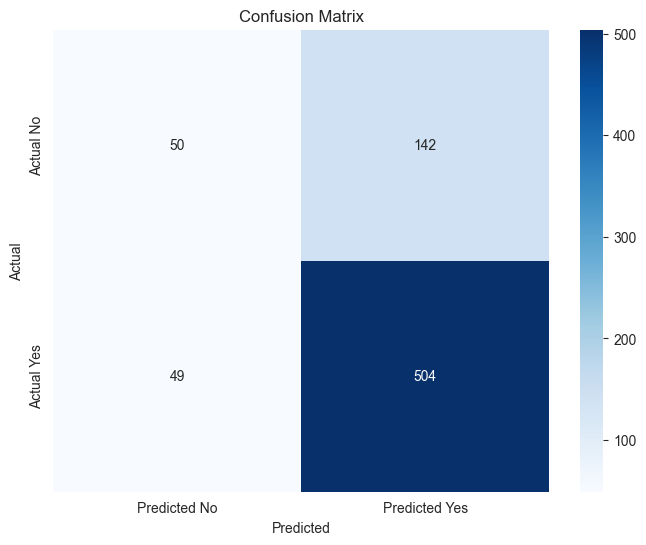

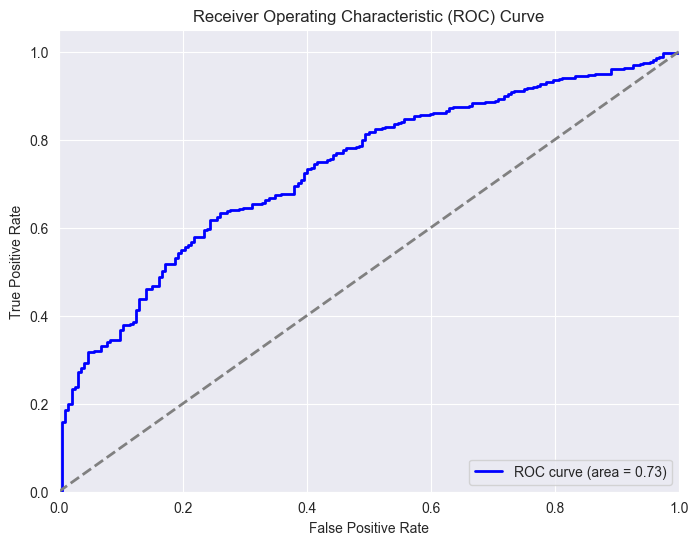

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
test_predictions = (best_clas_model.predict(test_d_matrix) > 0.5).astype(int)
test_proba = best_clas_model.predict(test_d_matrix)

# Accuracy
accuracy = accuracy_score(test_set.target, test_predictions)
print(f'Accuracy: {accuracy:.4f}')

# Precision, Recall, F1 Score
precision = precision_score(test_set.target, test_predictions)
recall = recall_score(test_set.target, test_predictions)
f1 = f1_score(test_set.target, test_predictions)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# ROC-AUC Score
roc_auc = roc_auc_score(test_set.target, test_proba)
print(f'ROC AUC Score: {roc_auc:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(test_set.target, test_predictions)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report
class_report = classification_report(test_set.target, test_predictions)
print('Classification Report:')
print(class_report)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(test_set.target, test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# If feature importance is applicable
if hasattr(best_clas_model, 'feature_importances_'):
    feature_importance = best_clas_model.feature_importances_
    feature_names = test_set.features.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Feature Importance')
    plt.show()


In [9]:
train["loss_proba"] = best_clas_model.predict(train_d_matrix)
test["loss_proba"] = best_clas_model.predict(test_d_matrix)

In [12]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from flaml import AutoML

DataSet = namedtuple('DataSet', ['features', 'target'])
train_set = DataSet(features=train.drop(columns=["Incurred_cat",'Incurred']), target=train["Incurred"])
test_set = DataSet(features=test.drop(columns=["Incurred_cat",'Incurred']), target=test["Incurred"])
train_d_matrix = xgb.DMatrix(train_set.features, label=train_set.target, enable_categorical=True)
test_d_matrix = xgb.DMatrix(test_set.features, label=test_set.target, enable_categorical=True)

# automl_regression = AutoML()
# 
# automl_reg_settings = {
#     "time_budget": 600,  # total running time in seconds
#     "metric": 'mse',  # metric to optimize
#     "task": 'regression',  # task type
#     "n_splits": 5,  # number of splits in time cross-validation
#     "sample": True,  # enable sampling
#     "estimator_list": ['xgboost'],  # list of ML algorithms to use
#     "log_file_name": 'flaml.log',  # log file
#     "eval_method": "cv",  # cross-validation
#     "max_iter": 200,  # maximum number of iterations
#     "early_stop": True,  # enable early stopping
#     "n_jobs": 4,  # number of parallel jobs
#     "ensemble": True,  # use ensemble methods
#     "custom_hp": {
#         'xgboost': {
#             'n_estimators': {'domain': randint(50, 500), 'init_value': 100},
#             'max_depth': {'domain': randint(3, 10), 'init_value': 6},
#             'subsample': {'domain': uniform(0.6, 1.0), 'init_value': 0.8},
#             'learning_rate': {'domain': uniform(0.1, 0.3), 'init_value': 0.1},
#         },
#     }
# }
# 
# automl_regression.fit(X_train=train_set.features, y_train=train_set.target, **automl_reg_settings)
# 
# print('Best hyperparameters:', automl_regression.best_config)

# best_params = automl_regression.best_config
best_reg_params = {'max_leaves': 4, 'min_child_weight': 9.013831375302424, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.002493586883585935, 'reg_lambda': 23.21315601383053, 'n_estimators': 142, 'learning_rate': 0.2172339422320672, 'subsample': 0.7982024057095053, 'max_depth': 7}
best_model = xgb.train(best_params, train_d_matrix, num_boost_round=100)

test_predictions = best_model.predict(test_d_matrix)
mae = mean_absolute_error(test_set.target, test_predictions)
print(f'Test MAE: {mae}')

Test MAE: 4001.048978509952


In [14]:
best_model.save_model("claims_model.json")